<a href="https://colab.research.google.com/github/sanjay-kv/450-DSA/blob/master/site/en/tutorials/keras/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
print(tf.__version__)

2.8.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 3s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'test', 'imdbEr.txt', 'README']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'unsupBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

#Task 0
Run the original tutorial (just the provided code applied to the IMDB dataset -- you don't have to do the StackOverflow exercise).  Call the neural network model defined in this tutorial OrigNN. Pay attention to the performance of the neural net on the dataset at each epoch.<br>

Changed the Model to OrginNN with Droupout layer 0.2

In [23]:
embedding_dim = 16

In [24]:
OrigNN = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

OrigNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

## Training the OrginNN Model

In [25]:
OrigNN.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [26]:
epochs = 10
history = OrigNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 10s 11ms/step - loss: 0.6658 - binary_accuracy: 0.6928 - val_loss: 0.6164 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5492 - binary_accuracy: 0.8013 - val_loss: 0.4983 - val_binary_accuracy: 0.8204
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4445 - binary_accuracy: 0.8446 - val_loss: 0.4199 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3775 - binary_accuracy: 0.8650 - val_loss: 0.3738 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3353 - binary_accuracy: 0.8788 - val_loss: 0.3452 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3052 - binary_accuracy: 0.8881 - val_loss: 0.3261 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

#Task 1 [1 mark]
Add a Dense hidden layer to the neural net in an appropriate place with (100 + 20 * N) neurons.  Call this network DenseNNi.  In your notebook, compare the performance of DenseNNi with OrigNN, considering the performance at each epoch, not just the final one.<br>
Hidden Layer : (100 +20*6) = 220<br>
Student ID : 46313966 Taking N as 6 <br>
N is th last digit of student ID<br>


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

In [27]:
DenseNNi = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(220,activation= tf.nn.relu),
  layers.Dense(1)])
DenseNNi.summary()

#created the model, run 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 220)               3740      
                                                                 
 dense_2 (Dense)             (None, 1)                 221       
                                                      

### DenseNNi Model Running # Task1

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [28]:
DenseNNi.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy. 

In [29]:
epochs = 10
history = DenseNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4848 - binary_accuracy: 0.7578 - val_loss: 0.3175 - val_binary_accuracy: 0.8692
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2642 - binary_accuracy: 0.8952 - val_loss: 0.2933 - val_binary_accuracy: 0.8762
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2087 - binary_accuracy: 0.9220 - val_loss: 0.3043 - val_binary_accuracy: 0.8770
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1706 - binary_accuracy: 0.9369 - val_loss: 0.3268 - val_binary_accuracy: 0.8740
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1435 - binary_accuracy: 0.9500 - val_loss: 0.3521 - val_binary_accuracy: 0.8732
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1232 - binary_accuracy: 0.9589 - val_loss: 0.3860 - val_binary_accuracy: 0.8682
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

# Summary (Model Comparison OrginNN, DenseNNI)

At Epoch1 the DenseNNi has less loss (0.2648) and better binary accuracy (0.8952) and at Epoch 2 the loss in OrginNN(0.5492) is high comparing the loss of DenseNNi and found the validation accuracy performed well than the binary accuracy. <br>
The same has trend has been observed in the OrginNN on Epoch 2,3,4, and Epoch 5, later from Epoch 6 there is higher binary accuracy compare the validation binary accuracy. At Epoch6 on OrginNN binary accuracy(0.881) and observed validation binary accuracy is 0.8708. but here the DenseNNi has better accuracy rate than the OrginNN with binary accuracy  0.9589. <br>

At Epoch 9 on OrginNN the loss is 0.2465 and binary accuracy 0.9114 and this is less comparing to the denseNN model. The Final Epoch10 model has a loss of 0.0731 binary accuracy scalled up to 0.9759 Whereas OrginNN model able to cimb up to 0.9158.

Binary accuracy neurons run in between and validation happens at the end of the process, thats why binary you see less value and validation high values initially and it get changed at the end. adding a Neural Network increase the perftion to the layers and loss is less and accuracy is high at the end.  

# Task 2 [1 marks]
In DenseNNi you should have two dropout layers, both with dropout hyperparameter 0.2.  In this task you're going to investigate the effect of changing the dropout hyperparameter.  Let D = 0.3 + 0.05 * N.  Investigate three new networks based on the new combinations of dropout hyperparameter, i.e.

first dropout layer has hyperparameter 0.2 and the second has hyperparameter D (call this model DenseNNii);
first dropout layer has hyperparameter D and the second has hyperparameter 0.2 (call this model DenseNNiii);
both dropout layers have hyperparameter D (call this model DenseNNiv).
In your notebook, compare the performance of all four variants of DenseNN with OrigNN, considering the performance at each epoch, not just the final one.  Which is the best?


#### Here D = (0.3+0.5 *N) where N is the Student ID last digiti which is 6 = 0.6

## DenseNNii with dropout layer has hyperparameter 0.2 and the second has hyperparameter D

In [53]:
DenseNNii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  # dropout reduce the neurins network, hence dependecy between neuron decrease and model perform better.
  layers.GlobalAveragePooling1D(), #pooling make the important val (highlighting val)
  layers.Dropout(0.6),
  layers.Dense(220,activation= tf.nn.relu),
  layers.Dense(1)])

DenseNNii.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_24 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 220)               3740      
                                                                 
 dense_18 (Dense)            (None, 1)                 221       
                                                      

# Train the model 

In [54]:
DenseNNii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Evaluate the model

In [55]:
epochs = 10
history = DenseNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5268 - binary_accuracy: 0.7290 - val_loss: 0.3362 - val_binary_accuracy: 0.8586
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3100 - binary_accuracy: 0.8738 - val_loss: 0.2956 - val_binary_accuracy: 0.8768
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2563 - binary_accuracy: 0.9007 - val_loss: 0.2912 - val_binary_accuracy: 0.8796
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2246 - binary_accuracy: 0.9154 - val_loss: 0.2934 - val_binary_accuracy: 0.8792
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2012 - binary_accuracy: 0.9250 - val_loss: 0.3065 - val_binary_accuracy: 0.8774
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1849 - binary_accuracy: 0.9312 - val_loss: 0.3150 - val_binary_accuracy: 0.8748
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

# DenseNiii Model (dropout layer has hyperparameter D and the second has hyperparameter 0.2)

In [56]:
DenseNNiii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.6),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(220,activation= tf.nn.relu),
  layers.Dense(1)])

DenseNNiii.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_26 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 220)               3740      
                                                                 
 dense_20 (Dense)            (None, 1)                 221       
                                                      

# Train the model 

In [57]:
DenseNNiii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Evaluate the model

In [58]:
epochs = 10
history = DenseNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1389 - binary_accuracy: 0.9505 - val_loss: 0.3717 - val_binary_accuracy: 0.8748
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1236 - binary_accuracy: 0.9558 - val_loss: 0.3923 - val_binary_accuracy: 0.8756
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1202 - binary_accuracy: 0.9564 - val_loss: 0.4176 - val_binary_accuracy: 0.8662
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1144 - binary_accuracy: 0.9596 - val_loss: 0.4229 - val_binary_accuracy: 0.8680
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1107 - binary_accuracy: 0.9605 - val_loss: 0.4281 - val_binary_accuracy: 0.8708
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1073 - binary_accuracy: 0.9625 - val_loss: 0.4453 - val_binary_accuracy: 0.8754
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

## DenseNNiv both dropout layers have hyperparameter D

In [59]:
DenseNNiv = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.6),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.6),
  layers.Dense(220,activation= tf.nn.relu),
  layers.Dense(1)])

DenseNNiv.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_28 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_9   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 220)               3740      
                                                                 
 dense_22 (Dense)            (None, 1)                 221       
                                                     

# Train the model 

In [60]:
DenseNNiv.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Evaluate the model

In [61]:
epochs = 10
history = DenseNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5645 - binary_accuracy: 0.6872 - val_loss: 0.3621 - val_binary_accuracy: 0.8530
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3543 - binary_accuracy: 0.8496 - val_loss: 0.3102 - val_binary_accuracy: 0.8730
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3109 - binary_accuracy: 0.8730 - val_loss: 0.2945 - val_binary_accuracy: 0.8782
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2809 - binary_accuracy: 0.8855 - val_loss: 0.2929 - val_binary_accuracy: 0.8772
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2645 - binary_accuracy: 0.8959 - val_loss: 0.2885 - val_binary_accuracy: 0.8816
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2509 - binary_accuracy: 0.8984 - val_loss: 0.2919 - val_binary_accuracy: 0.8790
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

## Summary Comparing the values of 4 Dense NN with OrginNN (Explanation Pending)
In Epoch 1 DenseNi of loss: 0.4848 - binary_accuracy: 0.7578 - val_loss: 0.3175 - val_binary_accuracy: 0.8692

DenseNii loss: 0.5268 - binary_accuracy: 0.7290 - val_loss: 0.3362 - val_binary_accuracy: 0.8586

DeseNiii loss: 0.1389 - binary_accuracy: 0.9505 - val_loss: 0.3717 - val_binary_accuracy: 0.8748


DenseNiv loss: 0.5645 - binary_accuracy: 0.6872 - val_loss: 0.3621 - val_binary_accuracy: 0.8530

OrginNN loss: 0.6658 - binary_accuracy: 0.6928 - val_loss: 0.6164 - val_binary_accuracy: 0.7718
---------------------------------

In Epoch 10 DenseNi of loss: 0.4848 - binary_accuracy: 0.7578 - val_loss: 0.3175 - val_binary_accuracy: 0.8692

DenseNii loss: 0.5268 - binary_accuracy: 0.7290 - val_loss: 0.3362 - val_binary_accuracy: 0.8586

DeseNiii loss: 0.1389 - binary_accuracy: 0.9505 - val_loss: 0.3717 - val_binary_accuracy: 0.8748


DenseNiv loss: 0.5645 - binary_accuracy: 0.6872 - val_loss: 0.3621 - val_binary_accuracy: 0.8530

OrginNN loss: 0.6658 - binary_accuracy: 0.6928 - val_loss: 0.6164 - val_binary_accuracy: 0.7718

### DenseNiii is the best model among this. 


#Task 3 [2 marks]
Use a CNN architecture rather than the dense network in the tutorial, with one Conv1D layer and one pooling layer, with kernel size K = (N div 2) + 5 (where div represents integer division), as in https://keras.io/examples/nlp/text_classification_from_scratch/.  Use the final dense and dropout layer as they do too.  As your network should (as in both examples) have a dropout layer immediately after the embedding layer, your network should consequently have two dropout layers; apply the same four combinations of dropout hyperparameters (selecting from 0.2, D) as in the previous tasks.  Call these four network variants CNNi, CNNii, CNNiii and CNNiv.  In your notebook, compare the performance of these, considering the performance at each epoch, not just the final one.  

Then choose the best of these four, and call it CNN.  In your notebook, compare the performance of CNN with the best of your previous networks (OrigNN, DenseNN), considering the performance at each epoch, not just the final one. <br>

### K (N/2 +5) = 8 & D is 0.6

## CNNi both dropout layers have hyperparameter 0.2

In [62]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(128, 8, padding="valid", activation="relu", strides=3)(x) #128 kernal size
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x) 
#2 drop out layer should be done here.

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNNi = tf.keras.Model(inputs, predictions)
CNNi.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model

In [68]:
epochs = 10

# Fit the model using the train and test datasets.
CNNi.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.1137 - accuracy: 0.9593 - val_loss: 0.3865 - val_accuracy: 0.8596
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0773 - accuracy: 0.9737 - val_loss: 0.4207 - val_accuracy: 0.8696
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0628 - accuracy: 0.9776 - val_loss: 0.5802 - val_accuracy: 0.8550
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0528 - accuracy: 0.9808 - val_loss: 0.5997 - val_accuracy: 0.8518
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0433 - accuracy: 0.9847 - val_loss: 0.5413 - val_accuracy: 0.8650
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0360 - accuracy: 0.9869 - val_loss: 0.5541 - val_accuracy: 0.8638
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0290 - accuracy: 0.9890 - val_loss: 0.6359 - val_accuracy: 0.8594
Epoch 

## *CNNii*  both dropout layers have hyperparameter 0.2 , 0.6

In [70]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(128, 8, padding="valid", activation="relu", strides=3)(x) #128 kernal size
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.6)(x) 
#2 drop out layer should be done here.

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNNii = tf.keras.Model(inputs, predictions)

CNNii.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [71]:
epochs = 10

# Fit the model using the train and test datasets.
CNNii.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.5283 - accuracy: 0.7084 - val_loss: 0.3490 - val_accuracy: 0.8538
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2927 - accuracy: 0.8827 - val_loss: 0.3393 - val_accuracy: 0.8532
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1982 - accuracy: 0.9249 - val_loss: 0.3248 - val_accuracy: 0.8730
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1275 - accuracy: 0.9568 - val_loss: 0.3634 - val_accuracy: 0.8682
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0845 - accuracy: 0.9724 - val_loss: 0.4444 - val_accuracy: 0.8644
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0620 - accuracy: 0.9780 - val_loss: 0.5201 - val_accuracy: 0.8640
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0528 - accuracy: 0.9819 - val_loss: 0.5350 - val_accuracy: 0.8644
Epoch 

## ## CNNiii both dropout layers have hyperparameter 0.6, 0.2

In [72]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.6)(x)
x = layers.Conv1D(128, 8, padding="valid", activation="relu", strides=3)(x) #128 kernal size
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x) 
#2 drop out layer should be done here.

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNNiii = tf.keras.Model(inputs, predictions)
CNNiii.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [73]:
epochs = 10

# Fit the model using the train and test datasets.
CNNiii.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.5423 - accuracy: 0.6966 - val_loss: 0.3647 - val_accuracy: 0.8428
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3369 - accuracy: 0.8565 - val_loss: 0.3147 - val_accuracy: 0.8632
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2783 - accuracy: 0.8856 - val_loss: 0.3065 - val_accuracy: 0.8722
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2445 - accuracy: 0.9003 - val_loss: 0.3182 - val_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2205 - accuracy: 0.9120 - val_loss: 0.3161 - val_accuracy: 0.8646
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2055 - accuracy: 0.9196 - val_loss: 0.3103 - val_accuracy: 0.8646
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1842 - accuracy: 0.9285 - val_loss: 0.3173 - val_accuracy: 0.8630
Epoch 

In [74]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.6)(x)
x = layers.Conv1D(128, 8, padding="valid", activation="relu", strides=3)(x) #128 kernal size
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.6)(x) 
#2 drop out layer should be done here.

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNNiv = tf.keras.Model(inputs, predictions)
CNNiv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [75]:
epochs = 10

# Fit the model using the train and test datasets.
CNNiv.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6282 - accuracy: 0.6030 - val_loss: 0.4012 - val_accuracy: 0.8322
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3767 - accuracy: 0.8372 - val_loss: 0.3223 - val_accuracy: 0.8616
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3018 - accuracy: 0.8800 - val_loss: 0.3105 - val_accuracy: 0.8668
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2637 - accuracy: 0.8935 - val_loss: 0.3063 - val_accuracy: 0.8702
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2336 - accuracy: 0.9094 - val_loss: 0.3080 - val_accuracy: 0.8692
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2081 - accuracy: 0.9194 - val_loss: 0.3098 - val_accuracy: 0.8690
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2018 - accuracy: 0.9200 - val_loss: 0.3176 - val_accuracy: 0.8710
Epoch 



CNNi: loss: 0.1137 - accuracy: 0.9593 - val_loss: 0.3865 - val_accuracy: 0.8596

CNNii: loss: 0.0189 - accuracy: 0.9928 - val_loss: 0.7192 - val_accuracy: 0.8604

CNNiii: loss: 0.5423 - accuracy: 0.6966 - val_loss: 0.3647 - val_accuracy: 0.8428

CNNiv: loss: 0.6282 - accuracy: 0.6030 - val_loss: 0.4012 - val_accuracy: 0.8322
---------------------------



CNNi: loss: 0.0189 - accuracy: 0.9928 - val_loss: 0.7192 - val_accuracy: 0.8604

CNNii: loss: loss: 0.0274 - accuracy: 0.9906 - val_loss: 0.6644 - val_accuracy: 0.8612

CNNiii: loss: 0.1595 - accuracy: 0.9385 - val_loss: 0.3496 - val_accuracy: 0.8594

CNNiv: loss: 0.1636 - accuracy: 0.9381 - val_loss: 0.3583 - val_accuracy: 0.8684


## CNNiii is the best model and calling that as CNN below.

In [76]:
#Find the best of the above and call it CNN
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.6)(x)
x = layers.Conv1D(128, 8, padding="valid", activation="relu", strides=3)(x) #128 kernal size
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x) 
#2 drop out layer should be done here.

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNN = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
CNN.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [77]:
epochs = 10

# Fit the model using the train and test datasets.
CNNiv.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1561 - accuracy: 0.9385 - val_loss: 0.3527 - val_accuracy: 0.8692
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1527 - accuracy: 0.9439 - val_loss: 0.3729 - val_accuracy: 0.8658
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1372 - accuracy: 0.9469 - val_loss: 0.3802 - val_accuracy: 0.8646
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1420 - accuracy: 0.9468 - val_loss: 0.3751 - val_accuracy: 0.8676
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1289 - accuracy: 0.9512 - val_loss: 0.4019 - val_accuracy: 0.8654
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1198 - accuracy: 0.9534 - val_loss: 0.3984 - val_accuracy: 0.8674
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1202 - accuracy: 0.9547 - val_loss: 0.4122 - val_accuracy: 0.8626
Epoch 

#Summary of the CNN and ORginNN, DenseNNi

OrginNN loss: 0.6658 - binary_accuracy: 0.6928 - val_loss: 0.6164 - val_binary_accuracy: 0.7718<br>

OrginNN loss: 0.6658 - binary_accuracy: 0.6928 - val_loss: 0.6164 - val_binary_accuracy: 0.7718

DenseNN Epoch 1: loss: 0.4848 - binary_accuracy: 0.7578 - val_loss: 0.3175 - val_binary_accuracy: 0.8692

DenseNN Epoch 10: loss: 0.0731 - binary_accuracy: 0.9759 - val_loss: 0.5409 - val_binary_accuracy: 0.8568
#yet to finish this

from the above DenseNN is the best NN and calling it has **NNBest**

# Task 4 [2 marks]
Choose the best of your previous architectures: call this NNBest.  Train the model on subsets of the original training data, of sizes (20%, 40%, 60%, 80%, 100%).  You should keep the validation set the same size for all training set sizes.  Plot the accuracies of the model for each of those training set sizes.  


#20% Data

We hhave to find the best

In [78]:
NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBest.summary()

NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
               metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
epochs = 10
train_size = int(0.2 * len(list(train_ds.as_numpy_iterator())))
train_dataset = train_ds.take(train_size)
history20 = NNBest.fit(
    train_dataset,
    validation_data=val_ds,
    epochs= epochs)

loss20, accuracy20 = NNBest.evaluate(test_ds)



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_44 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_10  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 16)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_______________________________________________

In [79]:
loss, accuracy = NNBest.evaluate(train_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

625/625 [==============================] - 1s 2ms/step - loss: 0.4863 - binary_accuracy: 0.8267
Loss:  0.48626455664634705
Accuracy:  0.82669997215271


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

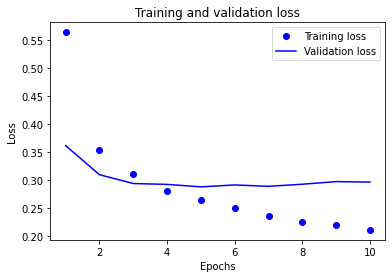

In [81]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

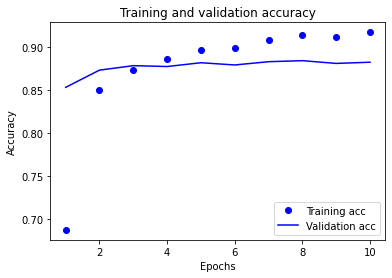

In [82]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## YEt to do with 40, 60, 80, 80 % of dATA

# Task 5 [1.5 marks]
Both of the preceding models (DNN, CNN) have been overtaken in NLP by Transformer models.  A well-known Transformer model is BERT.  Carry out the TensorFlow tutorial on BERT for text classification on the same dataset.  In this model, there is only one dropout layer.  Apply the model for the original value of 0.1 (BERTi) and the two values from earlier (0.2: BERTii; D: BERTiii).  In your notebook, compare the performance of these three variants of BERT with NNBest, considering the performance at each epoch, not just the final one.  Is there a similar pattern here as to which dropout hyperparameter is best?

Note: I've had a report that it might be difficult to train the BERT model on Colab for a full 5 epochs.  If this is the case for you, it's fine to report on the number of epochs you can successfully train for, just noting this in your report.

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [50]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  OrigNN,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3111 - accuracy: 0.8724
0.8723999857902527


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [51]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.59111214],
       [0.41116098],
       [0.33033472]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
